In [1]:
import sys # for automation and parallelization: set manual to false when run by a launcher
manual, scenario = (True, 'base') if 'ipykernel' in sys.argv[0] else (False, sys.argv[1])

# START

In [2]:
import sys
sys.path.insert(0, r'../../../quetzal')
from quetzal.model import stepmodel
import pandas as pd

PyTables is not installed. No support for HDF output.


In [3]:
training_folder = '../../'
plot_path = training_folder + 'outputs/plot/'

In [4]:
distribution = stepmodel.read_zippedpickles(training_folder + r'models/{scen}/distribution'.format(scen=scenario))  # OS requires volumes
sm = stepmodel.read_zippedpickles(training_folder + r'models/base/walk_model'.format(scen=scenario))

zone_to_transit: 100%|██████████| 29/29 [00:01<00:00, 24.51it/s]          


In [5]:
sm.volumes = distribution.volumes

# rail submodel

In [6]:
rail = sm.copy()
rail.links = rail.links.loc[rail.links['route_type'].isin(['tram', 'subway', 'rail'])] 

# strategy finder

In [7]:
rail.links['trip_id'] = rail.links['trip_id'].apply(lambda i: i.replace(':', '_').replace(' ', '_'))
rail.links= rail.links.loc[rail.links['a'] != rail.links['b']]

In [8]:
rail.nodes.index.name='index'
rail.step_strategy_finder()

  0%|          | 0/110 [00:00<?, ?it/s]

100%|██████████| 110/110 [00:05<00:00, 18.77it/s]


# assignment

In [9]:
rail.nodes.index.name='index'
rail.step_strategy_assignment('pt_captive')

100%|██████████| 110/110 [00:01<00:00, 55.58it/s]


In [10]:
import os
from graphviz import Source
os.environ["PATH"] += os.pathsep + r'C:\Program Files\Graphviz\bin/'
from IPython.core import display
import numpy as np
import networkx as nx

rail.links['trip_id'] = rail.links['trip_id'].apply(lambda i: i.replace(':', '_').replace(' ', '_'))

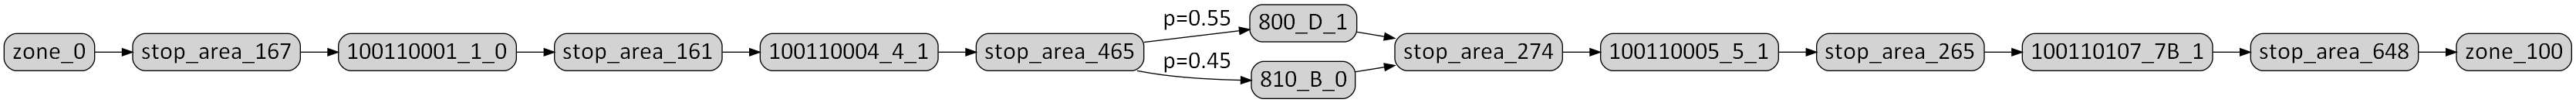

In [11]:
header = """
ratio = fill; 
node [style="filled,rounded" ,shape="record", fontname = "calibri", fontsize=24,];
edge[ fontname = "calibri", fontsize=24];
ranksep = "0.5";
rankdir="LR";
"""
origin, destination='zone_0',  'zone_100'
a = rail.get_aggregated_edges(origin, destination)
a['l'] = 'p=' + np.round(a['p'], 2).astype(str) #+ '\nh:' + a['h'].astype(str)
a.loc[a['p'] == 1, 'l'] = ''

odg = nx.DiGraph()
for e in a.to_dict(orient='records'):
    odg.add_edge(e['i'], e['j'], label=e['l'])
name='test'
dot_string = nx.nx_pydot.to_pydot(odg).to_string().replace('{', '{' + header)
src = Source(dot_string,format='png')
display.Image(filename=src.render(name))

In [12]:
self = rail
edges = self.optimal_strategy_edges[['i', 'j', 'f', 'c']].copy()
edges = edges.loc[self.optimal_strategy_sets.loc[destination]]
edges['ix'] = edges.index

# removing the edges that are non relevant (p<1e-6)
f_total = edges.groupby('i')[['f']].sum()
edges = pd.merge(edges, f_total, left_on='i', right_index=True, suffixes=['', '_total'])
edges['p'] = np.round(edges['f'] / edges['f_total'], 6)
edges = edges.loc[edges['p'] > 0]

In [13]:
#restriction to the origin
g = nx.DiGraph()
for e in edges.to_dict(orient='records'):
    g.add_edge(e['i'], e['j'])

paths = list(nx.all_simple_paths(g, source=origin, target=destination))
nodes = set.union(*[set(p) for p in paths])
ode = edges.loc[edges['i'].isin(nodes) & edges['j'].isin(nodes)]

In [14]:
rail.links.groupby(['a', 'b', 'trip_id']).first()

index  link_sequence  \
a             b             trip_id                                      
stop_area_0   stop_area_226 100110008_8_1          4670             18   
              stop_area_385 100110008_8_2          4692             12   
stop_area_1   stop_area_55  100110011_11_1         4834              3   
              stop_area_813 100110011_11_0         4830             10   
stop_area_10  stop_area_29  100112013_T3A_0        5079             17   
...                                                 ...            ...   
stop_area_975 stop_area_110 800_C_RapidTransit_4   5185              2   
              stop_area_255 800_C_RapidTransit_1   5167             13   
                            800_C_RapidTransit_3   5183              8   
stop_area_991 stop_area_817 100112013_T3A_0        5069              7   
              stop_area_829 100112013_T3A_1        5105             19   

                                                  departure_time  \
a             b             trip_id                                
stop_area_0   stop_area_226 100110008_8_1                33420.0   
              stop_area_385 100110008_8_2                32880.0   
stop_area_1   stop_area_55  100110011_11_1               28140.0   
              stop_area_813 100110011_11_0               29100.0   
stop_area_10  stop_area_29  100112013_T3A_0              28920.0   
...                                                          ...   
stop_area_975 stop_area_110 800_C_RapidTransit_4         32280.0   
              stop_area_255 800_C_RapidTransit_1         33120.0   
                            800_C_RapidTransit_3         31200.0   
stop_area_991 stop_area_817 100112013_T3A_0              27840.0   
              stop_area_829 100112013_T3A_1              28620.0   

                                                  arrival_time   time  \
a             b             trip_id                                     
stop_area_0   stop_area_226 100110008_8_1              33480.0   60.0   
              stop_area_385 100110008_8_2              33000.0  120.0   
stop_area_1   stop_area_55  100110011_11_1             28200.0   60.0   
              stop_area_813 100110011_11_0             29160.0   60.0   
stop_area_10  stop_area_29  100112013_T3A_0            29040.0  120.0   
...                                                        ...    ...   
stop_area_975 stop_area_110 800_C_RapidTransit_4       32460.0  180.0   
              stop_area_255 800_C_RapidTransit_1       33240.0  120.0   
                            800_C_RapidTransit_3       31320.0  120.0   
stop_area_991 stop_area_817 100112013_T3A_0            27960.0  120.0   
              stop_area_829 100112013_T3A_1            28680.0   60.0   

                                                  headway  \
a             b             trip_id                         
stop_area_0   stop_area_226 100110008_8_1             138   
              stop_area_385 100110008_8_2             133   
stop_area_1   stop_area_55  100110011_11_1            106   
              stop_area_813 100110011_11_0            109   
stop_area_10  stop_area_29  100112013_T3A_0           212   
...                                                   ...   
stop_area_975 stop_area_110 800_C_RapidTransit_4      900   
              stop_area_255 800_C_RapidTransit_1      225   
                            800_C_RapidTransit_3      200   
stop_area_991 stop_area_817 100112013_T3A_0           212   
              stop_area_829 100112013_T3A_1           225   

                                                            pattern_id  \
a             b             trip_id                                      
stop_area_0   stop_area_226 100110008_8_1                100110008:8_1   
              stop_area_385 100110008_8_2                100110008:8_2   
stop_area_1   stop_area_55  100110011_11_1              100110011:11_1   
              stop_area_813 100110011_11_0              100110011:11_0   
stop_area_10  